<a href="https://colab.research.google.com/github/aayush9753/OCR---Text-Extraction/blob/main/Text_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""import requests  
file_url = "https://github.com/ZER-0-NE/EAST-Detector-for-text-detection-using-OpenCV/blob/master/frozen_east_text_detection.pb"
    
r = requests.get(file_url, stream = True)  
  
with open("/content/drive/My Drive/frozen_east_text_detection.pb", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)  """

In [ ]:
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
!pip install pytesseract
import pytesseract
from matplotlib import pyplot as plt

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=f4fbc33f6fbf98b89202ae1cc6854f08adfc09096ddb7c6e57df3ffba16dd96f
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [ ]:
#Creating argument dictionary for the default arguments needed in the code. 
args = {"image":"/content/drive/MyDrive/text.jpg", "east":"/content/drive/MyDrive/frozen_east_text_detection.pb", "min_confidence":0.3, "width":320, "height":320}

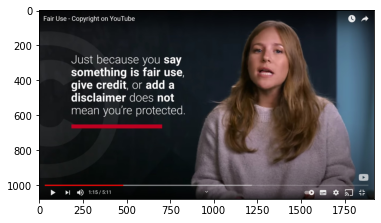

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(args['image']), cv2.COLOR_BGR2RGB))

In [ ]:
args['image']="/content/drive/MyDrive/text.jpg"
image = cv2.imread(args['image'])

In [ ]:
image.shape

(1080, 1920, 3)

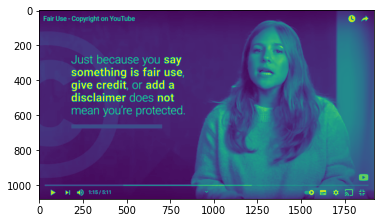

In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

In [ ]:


#Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [ ]:
# load the pre-trained EAST model for text detection 
net = cv2.dnn.readNet(args["east"])

# We would like to get two outputs from the EAST model. 
#1. Probabilty scores for the region whether that contains text or not. 
#2. Geometry of the text -- Coordinates of the bounding box detecting a text
# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [ ]:
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [ ]:
geometry.shape, geometry[...,0,0]

((1, 5, 80, 80),
 array([[ 1.3080205e+02,  8.2867294e+01,  4.0974468e+01,  1.6785739e+02,
         -3.8351655e-02]], dtype=float32))

In [ ]:
scores.shape, scores.shape[2:4], scores[0, 0, 0].shape

((1, 1, 80, 80), (80, 80), (80,))

In [ ]:
## Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

In [ ]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

In [ ]:
boxes

array([[ 31, 137,  83, 156],
       [ 29,   8,  93,  20],
       [ 27, 118,  52, 137],
       [ 50, 157, 139, 179],
       [ 54, 117,  88, 135],
       [112,  96, 140, 115],
       [114,  75, 138,  92],
       [ 30,  73,  61,  91],
       [ 30,  96,  70, 114],
       [ 98, 113, 128, 137],
       [ 83, 140, 113, 157],
       [  0,   7,  26,  19],
       [111, 137, 129, 158],
       [ 45, 301,  70, 313],
       [ 54,  76,  82,  90],
       [ 21, 300,  45, 316],
       [289,   6, 315,  22]])

In [ ]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.4 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [550 kB]
Get:12

In [ ]:
##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l eng --oem 1 --psm 3")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r, config=configuration)
  

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))


disclaimer


- Copyright on YouTube




in youre protected.


credit.


r use,


| Sav


Just b


somethi


add a


does


ra aks


not


1:15/ 5:11


necal


rl i)






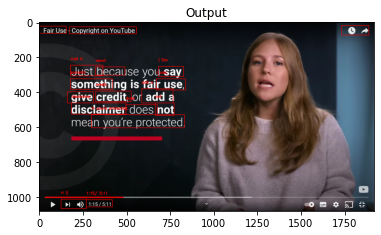

In [ ]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.title('Output')
plt.show()